In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy.io as sio # To import Matlab stuff

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection
from matplotlib.colors import LinearSegmentedColormap

import cStringIO
from PIL import Image

In [4]:
import sys
sys.path.append('../antworld')

###Loading the ant world

In [5]:
data_folder = '../data/seville/'
world_name = 'world5000_gray.mat'

matlab_world  = sio.loadmat(data_folder + world_name)

Load polygons. Each row of X, Y and Z is a triangle (3 values)

In [6]:
X = matlab_world['X']
Y = matlab_world['Y']
Z = matlab_world['Z']
colp = matlab_world['colp'] # The colour data for each polygon.

X.shape

(5000, 3)

Now load the ant routes. Each row contains position $x$, $y$ and heading $\theta$ for each reading.

In [7]:
matlab_routes  = sio.loadmat(data_folder + 'AntRoutes.mat')
ant1_route1 = matlab_routes['Ant1_Route1']

Rescale X and Y by 100

In [8]:
ant1_route1[:, 0:2] = ant1_route1[:,0:2] / 100

Convert heading to rad

In [9]:
ant1_route1[:, 2] = np.deg2rad(ant1_route1[:,2])

###Display an ant route from above

We can set the colour of each polygon using colp. Here it is just used for shading as all gray.

In [10]:
alpha = 0.7
colours = np.hstack((colp, np.ones([colp.shape[0], 1]) * alpha))

Plotting both the world and routes from above

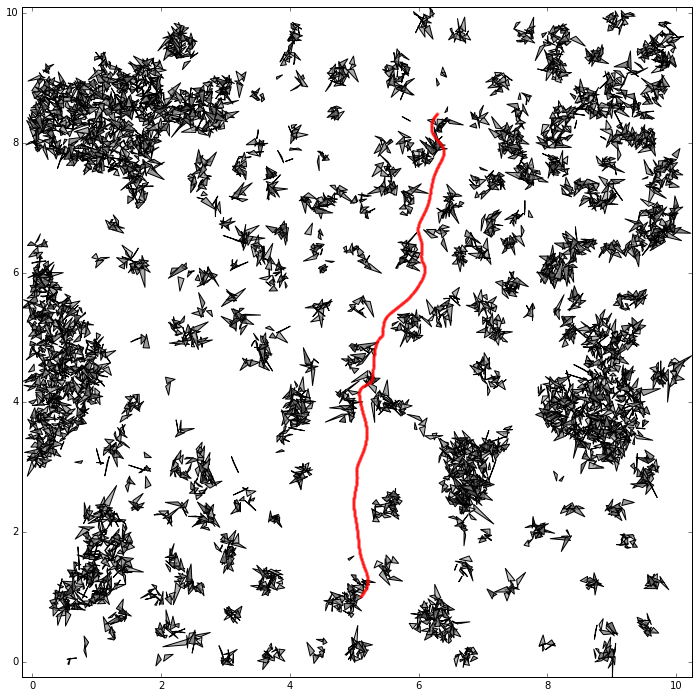

In [11]:
fig, ax = plt.subplots(figsize=(12,12))

# Add the world polygons
grass_verts = np.dstack((X, Y))
p = PolyCollection(grass_verts, facecolor=colours)
ax.add_collection(p)

# Add the ant route
ax.scatter(ant1_route1[:,0], ant1_route1[:,1], color='red', s=5, alpha=0.3)

ax.set_xlim([np.min(X), np.max(X)])
ax.set_ylim([np.min(Y), np.max(Y)])
plt.show()

###Getting a first person view
To create a first person view the polygons are converted to spherical coordinates relative to current position and pose. The axes of the rectangular view image are then set to $\theta$ and $\phi$.

First we set a current position.

In [12]:
x, y, th = ant1_route1[200,:]
z = 0.01

x, y, z, th

(6.002960847855368, 6.6108557136591823, 0.01, -1.352151903593938)

Get location of all polygons relative to position in spherical coordinates.

In [13]:
def cart2sph(X, Y, Z):
    """Converts cartesian to spherical coordinates.
    Works on matrices so we can pass in e.g. X with rows of len 3 for polygons."""
    
    XY = X**2 + Y**2
    TH = np.arctan2(Y, X) #theta
    #PHI = np.arctan2(np.sqrt(xy), z) #phi: elevation from Z axis down
    PHI = np.arctan2(Z, np.sqrt(XY)) #phi: elevation from XY plane up
    R = np.sqrt(XY + Z**2) #r
    
    return (TH, PHI, R)

In [14]:
TH, PHI, R = cart2sph(X-x, Y-y, np.abs(Z)-z)

... and relative to heading as well.

In [15]:
def pi2pi(theta):
    """Constrains value to lie between -pi and pi."""
    return np.mod(theta + np.pi, 2 * np.pi) - np.pi

In [16]:
TH_rel = pi2pi(TH - th)

Check for blades of grass that loop from one side of the image to the other.

To do this some duplicates need to be added so that grass blades going off the sides are rendered twice.

In [17]:
# Find all indices with wider than pi grass blades
ind = (np.max(TH_rel, axis=1) - np.min(TH_rel, axis=1)) > np.pi

# Create positive and negative duplicates.
TH_rel_ext = np.vstack((TH_rel, np.mod(TH_rel[ind, :] - 2*np.pi, -2*np.pi)))
TH_rel_ext[ind, :] = np.mod(TH_rel[ind, :] + 2*np.pi, 2*np.pi)

# Include the duplicated indices on the other arrays.
PHI_ext = np.vstack((PHI, PHI[ind, :]))
R_ext = np.vstack((R, R[ind, :]))
colours_ext = np.vstack((colours, colours[ind]))

colours_ext.shape

(5007, 4)

The ant eye approximate resolution

In [18]:
resolution = 0.4 # Degrees per pixel

Axis according to FOV

In [19]:
hfov_deg = 296.0
hfov = np.deg2rad(hfov_deg)
h_min = -hfov / 2
h_max = hfov / 2

In [20]:
h_pixels = hfov_deg / resolution

Vertical field of view values to approximate 75 degrees in literature

In [21]:
v_max = np.pi / 3
v_min = -np.pi / 12
vfov = v_max - v_min

In [22]:
image_ratio = vfov / hfov
v_pixels = h_pixels * image_ratio

Calculate the image dimensions in inches (for Figure output)

In [23]:
dpi = 100 # Set to this as it makes it easy to specify pixels
im_width = h_pixels / dpi
im_height = v_pixels / dpi

The sky is just the plot background colour.

In [24]:
sky_colour = 'cyan'

Create the ground

In [25]:
ground_colour = np.array([229.0, 183.0, 90.0]) / 255

In [26]:
ground_verts = [[(h_min, v_min),
                 (h_max, v_min),
                 (h_max, 0),
                 (h_min, 0)]]

g = PolyCollection(ground_verts,
                   facecolor=ground_colour,
                   edgecolor='none')

Sort grass by distance and create a green colour map.

In [27]:
sorted_idxs = np.argsort(np.mean(R_ext, axis=1))[::-1]

In [28]:
grass_cmap = LinearSegmentedColormap.from_list('mycmap', [(0, (0,0,0,1)),
                                                          (1, (0,1,0,1))]
                                              )

Now plot the polygons using Matplotlib

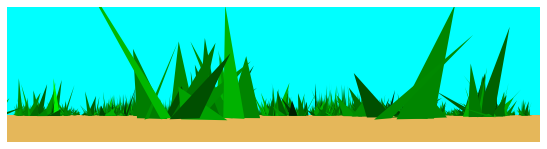

In [29]:
fig = plt.figure(frameon=False, figsize=(im_width, im_height), dpi=100)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)

ax.add_collection(g)

grass_verts = np.dstack((TH_rel_ext, PHI_ext))[sorted_idxs,:,:]

p = PolyCollection(grass_verts, cmap=grass_cmap)
p.set_edgecolor('none')
grass_colours = colours_ext[sorted_idxs, 0]
p.set_array(grass_colours)
ax.add_collection(p)

ax.set_ylim(v_min, v_max)
ax.set_xlim(h_min, h_max)
ax.set_axis_bgcolor(sky_colour)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

There seem to be two methods to get the image as a numpy array... with different interpolation methods used?

(187, 740, 3)


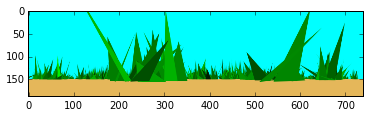

In [30]:
#%%timeit # 10 loops, best of 3: 86 ms per loop BUT doesn't seem to matter on world_viewer
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

print data.shape
plt.imshow(data)

(187, 740, 4)


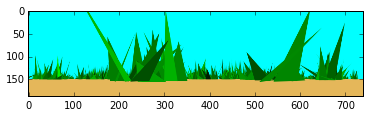

In [31]:
#%%timeit # 10 loops, best of 3: 141 ms per loop BUT doesn't seem to matter on world_viewer
imgdata = cStringIO.StringIO()
fig.savefig(imgdata, format='png', pad_inches=0, dpi=dpi)
imgdata.seek(0)  # rewind the data
im = Image.open(imgdata)
data = np.asarray(im)

print data.shape
plt.imshow(data[:,:,0:3])

###The WorldViewer class
If we put all the above in a Class to get an image from location and heading...

In [32]:
from world_viewer import WorldViewer
wv = WorldViewer(X, Y, Z, colp[:,0], resolution=4, data_folder='../data/world_images', world_name='notebook')

(18, 74, 3)


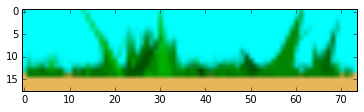

In [33]:
current_view = wv.get_view(x=x, y=y, th=th)

print current_view.shape
plt.imshow(current_view)

You can also save the view as a png file. (Check `wv.data_folder/wv.world_name`) for output png

In [34]:
wv.save_view(x=x, y=y, th=th)

In [35]:
def view_route():
    for location in ant1_route1[::100,:]:
        plt.figure()
        plt.imshow(wv.get_view(x=location[0], y=location[1], th=location[2]))

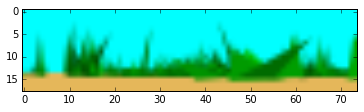

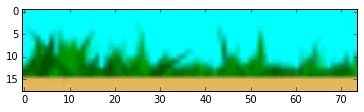

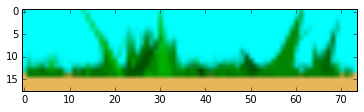

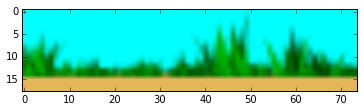

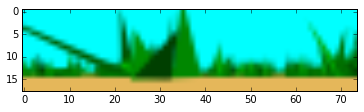

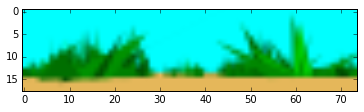

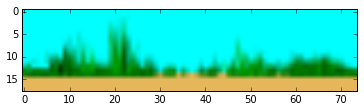

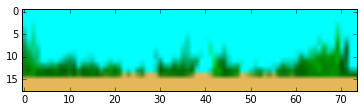

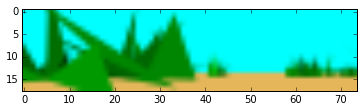

In [36]:
%prun view_route() # Currently takes about 0.5 secs per frame

#view_route()

###Alternative method

Use a 3d plot and move the view around instead of re-plotting all these patches.

For this we need to adjust the projection matrix to get a wide field of view.

Not figured out how to do this yet.

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [38]:
X_ground3d = np.array([0, 0, 10.5, 10.5])
Y_ground3d = np.array([0, 10.5, 10.5, 0])
Z_ground3d = np.array([0, 0, 0, 0])

ground_verts = np.dstack((X_ground3d, Y_ground3d, Z_ground3d))
p_ground = Poly3DCollection(ground_verts,
                            facecolor=ground_colour,
                            edgecolor='none')

In [39]:
grass_verts = np.dstack((X, Y, Z))
p_grass = Poly3DCollection(grass_verts,
                           array=colours[:,0],
                           edgecolor='none',
                           cmap=grass_cmap)

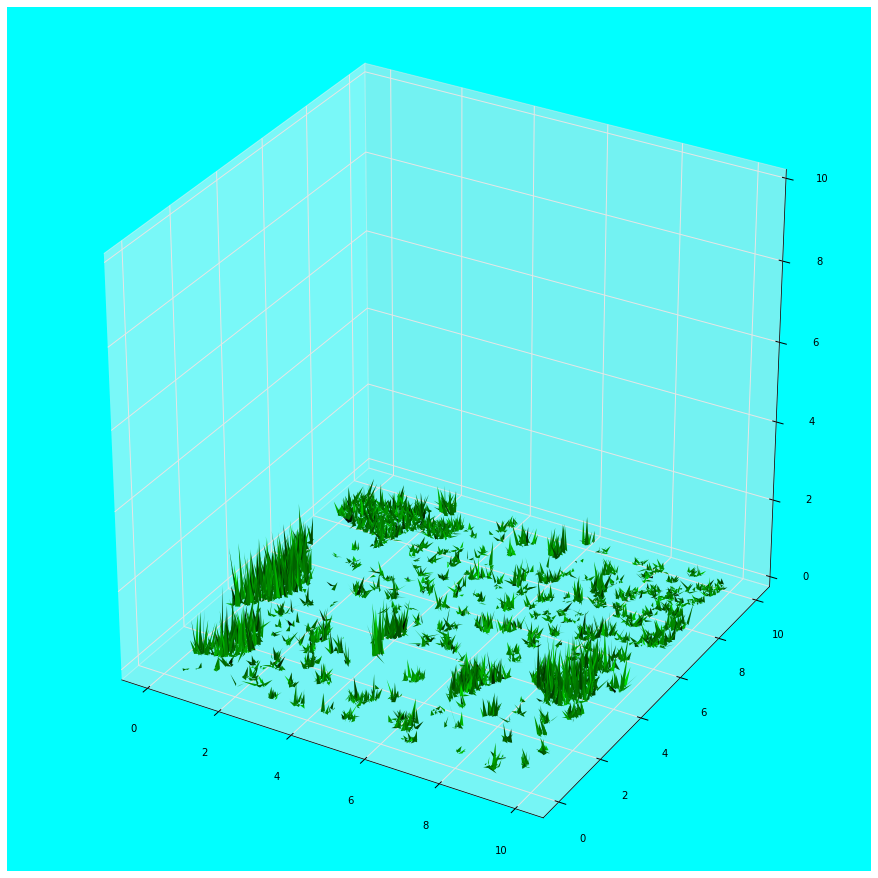

In [40]:
fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)

#ax.add_collection3d(p_ground)

ax.add_collection3d(p_grass)

ax.set_xlim([-0.5, 10.5])
ax.set_ylim([-0.5, 10.5])
ax.set_zlim([-0.05, 10])
ax.set_axis_bgcolor(sky_colour)

# Set the view
#ax.view_init(elev=0, azim=0)
#ax.dist=5

plt.show()

In [41]:
ax.get_proj()

array([[  0.07872958,   0.04545455,   0.        ,  -0.62092064],
       [ -0.02272727,   0.03936479,   0.08617168,  -0.51189171],
       [  0.        ,   0.        ,   0.        , -10.        ],
       [ -0.03936479,   0.06818182,  -0.04975124,  10.1034273 ]])